In [1]:
import numpy as np # library to handle data in a vectorized manner
import time
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import folium 
from folium import plugins

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans


In [2]:
address = 'Mccallum Street, Singapore'
geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Singapore home are {}, {}.'.format(latitude, longitude))

C:\Users\93595\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Using Nominatim with the default "geopy/1.22.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  


The geograpical coordinate of Singapore home are 1.2784801, 103.8493717.


In [4]:
neighborhood_latitude=1.2784801
neighborhood_longitude=103.8493717

In [5]:
CLIENT_ID = 'HYC5MAL35HQMFNZRAMZFWRSATHU5M4FBYZLGGAEAVYZLRWGY' # your Foursquare ID
CLIENT_SECRET = 'IP0IYEB0Q2TWHGXR3IWBBK0AYU5NSOZSEPFCQWVXQLRDBUQT' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: HYC5MAL35HQMFNZRAMZFWRSATHU5M4FBYZLGGAEAVYZLRWGY
CLIENT_SECRET:IP0IYEB0Q2TWHGXR3IWBBK0AYU5NSOZSEPFCQWVXQLRDBUQT


In [6]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=HYC5MAL35HQMFNZRAMZFWRSATHU5M4FBYZLGGAEAVYZLRWGY&client_secret=IP0IYEB0Q2TWHGXR3IWBBK0AYU5NSOZSEPFCQWVXQLRDBUQT&v=20180605&ll=1.2784801,103.8493717&radius=500&limit=100'

In [7]:
results = requests.get(url).json()

In [8]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [9]:
venues = results['response']['groups'][0]['items']
SGnearby_venues = json_normalize(venues) # flatten JSON
# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
SGnearby_venues =SGnearby_venues.loc[:, filtered_columns]
# filter the category for each row
SGnearby_venues['venue.categories'] = SGnearby_venues.apply(get_category_type, axis=1)
# clean columns
SGnearby_venues.columns = [col.split(".")[-1] for col in SGnearby_venues.columns]

SGnearby_venues.shape

(76, 4)

In [10]:
SGnearby_venues.head(10)

,name,categories,lat,lng
0,The Westin Singapore,Hotel,1.278275,103.850772
1,Pure Fitness,Gym,1.278631,103.851487
2,Lau Pa Sat Satay Street,Street Food Gathering,1.280261,103.850235
3,Anglo Indian Cafe & Bar,Indian Restaurant,1.279084,103.850127
4,Westin Infinity Pool,Pool,1.278057,103.851077
5,Napoleon Food & Wine Bar,Wine Bar,1.279925,103.847333
6,Sofitel So Singapore,Hotel,1.280017,103.849813
7,Lobby Lounge Westin,Bar,1.277811,103.850966
8,Mellower Coffee,Café,1.277814,103.848188
9,Cook & Brew,Gastropub,1.277842,103.851103


In [11]:
latitude=1.2792655
longitude=103.8480938
# create map of Singapore place  using latitude and longitude values
map_sg = folium.Map(location=[latitude, longitude], zoom_start=18)
# add markers to map
for lat, lng, label in zip(SGnearby_venues['lat'], SGnearby_venues['lng'], SGnearby_venues['name']):
    label = folium.Popup(label, parse_html=True)
    folium.RegularPolygonMarker(
        [lat, lng],
        number_of_sides=30,
        radius=7,
        popup=label,
        color='blue',
        fill_color='#0f0f0f',
        fill_opacity=0.6,
    ).add_to(map_sg)  
    
map_sg


In [12]:
manhattan_data  = pd.read_csv('mh_neigh_data.csv') 
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels
0,Manhattan,Marble Hill,40.876551,-73.910660,2
1,Manhattan,Chinatown,40.715618,-73.994279,2
2,Manhattan,Washington Heights,40.851903,-73.936900,4
3,Manhattan,Inwood,40.867684,-73.921210,3
4,Manhattan,Hamilton Heights,40.823604,-73.949688,0


In [13]:
manhattan_data.tail()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels
35,Manhattan,Turtle Bay,40.752042,-73.967708,3
36,Manhattan,Tudor City,40.746917,-73.971219,3
37,Manhattan,Stuyvesant Town,40.731000,-73.974052,4
38,Manhattan,Flatiron,40.739673,-73.990947,3
39,Manhattan,Hudson Yards,40.756658,-74.000111,2


In [15]:
manhattan_merged = pd.read_csv('manhattan_merged.csv')
manhattan_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,2,Coffee Shop,Discount Store,Yoga Studio,Steakhouse,Supplement Shop,Tennis Stadium,Shoe Store,Gym,Bank,Seafood Restaurant
1,Manhattan,Chinatown,40.715618,-73.994279,2,Chinese Restaurant,Cocktail Bar,Dim Sum Restaurant,American Restaurant,Vietnamese Restaurant,Salon / Barbershop,Noodle House,Bakery,Bubble Tea Shop,Ice Cream Shop
2,Manhattan,Washington Heights,40.851903,-73.936900,4,Cafe,Bakery,Mobile Phone Shop,Pizza Place,Sandwich Place,Park,Gym,Latin American Restaurant,Tapas Restaurant,Mexican Restaurant
3,Manhattan,Inwood,40.867684,-73.921210,3,Mexican Restaurant,Lounge,Pizza Place,Cafe,Wine Bar,Bakery,American Restaurant,Park,Frozen Yogurt Shop,Spanish Restaurant
4,Manhattan,Hamilton Heights,40.823604,-73.949688,0,Mexican Restaurant,Coffee Shop,Cafe,Deli / Bodega,Pizza Place,Liquor Store,Indian Restaurant,Sushi Restaurant,Sandwich Place,Yoga Studio


In [16]:
latitude= 40.7308619
longitude= -73.9871558 

kclusters=5
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=20,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
  # add markers for rental places to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters)    
    
       
map_clusters

In [17]:
kk = 2
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == kk, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Marble Hill,Coffee Shop,Discount Store,Yoga Studio,Steakhouse,Supplement Shop,Tennis Stadium,Shoe Store,Gym,Bank,Seafood Restaurant
1,Chinatown,Chinese Restaurant,Cocktail Bar,Dim Sum Restaurant,American Restaurant,Vietnamese Restaurant,Salon / Barbershop,Noodle House,Bakery,Bubble Tea Shop,Ice Cream Shop
6,Central Harlem,African Restaurant,Seafood Restaurant,French Restaurant,American Restaurant,Cosmetics Shop,Chinese Restaurant,Event Space,Liquor Store,Beer Bar,Gym / Fitness Center
9,Yorkville,Coffee Shop,Gym,Bar,Italian Restaurant,Sushi Restaurant,Pizza Place,Mexican Restaurant,Deli / Bodega,Japanese Restaurant,Pub
14,Clinton,Theater,Italian Restaurant,Coffee Shop,American Restaurant,Gym / Fitness Center,Hotel,Wine Shop,Spa,Gym,Indie Theater
23,Soho,Clothing Store,Boutique,Women's Store,Shoe Store,Men's Store,Furniture / Home Store,Italian Restaurant,Mediterranean Restaurant,Art Gallery,Design Studio
26,Morningside Heights,Coffee Shop,American Restaurant,Park,Bookstore,Pizza Place,Sandwich Place,Burger Joint,Cafe,Deli / Bodega,Tennis Court
34,Sutton Place,Gym / Fitness Center,Italian Restaurant,Furniture / Home Store,Indian Restaurant,Dessert Shop,American Restaurant,Bakery,Juice Bar,Boutique,Sushi Restaurant
39,Hudson Yards,Coffee Shop,Italian Restaurant,Hotel,Theater,American Restaurant,Cafe,Gym / Fitness Center,Thai Restaurant,Restaurant,Gym


In [18]:
mh_rent=pd.read_csv('MH_flats_price.csv')
mh_rent.head()

,Address,Area,Price_per_ft2,Rooms,Area-ft2,Rent_Price,Lat,Long
0,West 105th Street,Upper West Side,2.94,5.0,3400,10000,NaN,NaN
1,East 97th Street,Upper East Side,3.57,3.0,2100,7500,NaN,NaN
2,West 105th Street,Upper West Side,1.89,4.0,2800,5300,NaN,NaN
3,CARMINE ST.,West Village,3.03,2.0,1650,5000,NaN,NaN
4,171 W 23RD ST.,Chelsea,3.45,2.0,1450,5000,NaN,NaN


In [19]:
mh_rent.tail()

,Address,Area,Price_per_ft2,Rooms,Area-ft2,Rent_Price,Lat,Long
139,200 East 72nd Street,Rental in Lenox Hill,5.15,3.0,1700,8750,NaN,NaN
140,50 Murray Street,No fee rental in Tribeca,7.11,2.0,1223,8700,NaN,NaN
141,300 East 56th Street,No fee rental in Midtown East,3.87,3.0,2100,8118,NaN,NaN
142,1930 Broadway,No fee rental in Central Park West,5.06,2.0,1600,8095,NaN,NaN
143,33 West 9th Street,Rental in Greenwich Village,6.67,2.0,1500,10000,NaN,NaN


In [21]:
mh_rent=pd.read_csv('MH_rent_latlog.csv')
mh_rent.head()

,Address,Area,Price_per_ft2,Rooms,Area-ft2,Rent_Price,Lat,Long
0,West 105th Street,Upper West Side,2.94,5.0,3400,10000,40.799771,-73.966213
1,East 97th Street,Upper East Side,3.57,3.0,2100,7500,40.788585,-73.955277
2,West 105th Street,Upper West Side,1.89,4.0,2800,5300,40.799771,-73.966213
3,CARMINE ST.,West Village,3.03,2.0,1650,5000,40.730523,-74.001873
4,171 W 23RD ST.,Chelsea,3.45,2.0,1450,5000,40.744118,-73.995299


In [22]:
mh_rent.tail()

,Address,Area,Price_per_ft2,Rooms,Area-ft2,Rent_Price,Lat,Long
139,200 East 72nd Street,Rental in Lenox Hill,5.15,3.0,1700,8750,40.769465,-73.960339
140,50 Murray Street,No fee rental in Tribeca,7.11,2.0,1223,8700,40.714051,-74.009608
141,300 East 56th Street,No fee rental in Midtown East,3.87,3.0,2100,8118,40.758216,-73.965190
142,1930 Broadway,No fee rental in Central Park West,5.06,2.0,1600,8095,40.772474,-73.981901
143,33 West 9th Street,Rental in Greenwich Village,6.67,2.0,1500,10000,40.733691,-73.997323


In [23]:
import matplotlib.pyplot as plt
import itertools
import seaborn as sb
import random
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline


sb.set_style('whitegrid', {'legend.frameon': True})
colors_ = ['yellowgreen', 'lightskyblue','lightcoral', 'gold', 'gray']
random.seed(134)
palette = sb.color_palette(colors_)
sb.set_palette(palette)
sb.set(font_scale=1.2)

No handles with labels found to put in legend.


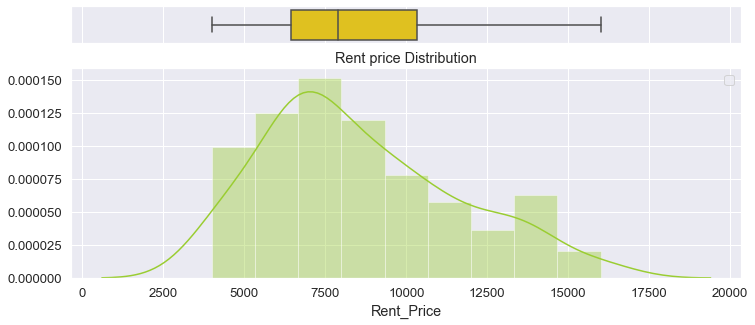

In [24]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)},figsize=(12,5))
sb.boxplot(mh_rent['Rent_Price'], ax=ax_box,color = colors_[3])
sb.distplot(mh_rent['Rent_Price'], color = colors_[0],ax=ax_hist)
plt.title("Rent price Distribution")
plt.legend()
ax_box.set(xlabel='')
plt.show()

No handles with labels found to put in legend.


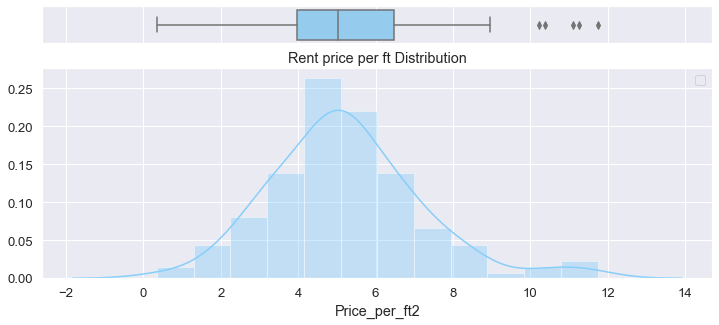

In [25]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)},figsize=(12,5))
sb.boxplot(mh_rent['Price_per_ft2'], ax=ax_box,color = colors_[1])
sb.distplot(mh_rent['Price_per_ft2'], color = colors_[1],ax=ax_hist)
plt.title("Rent price per ft Distribution")
plt.legend()
ax_box.set(xlabel='')
plt.show()

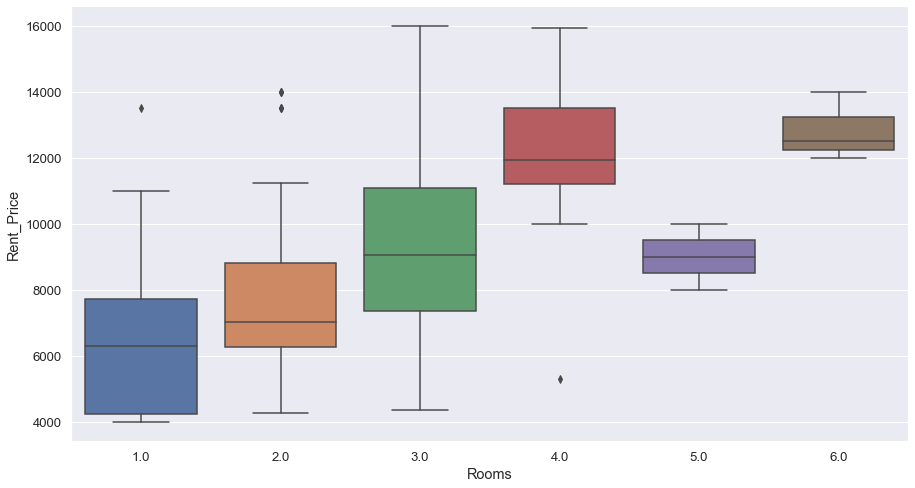

In [26]:
fig, ax = plt.subplots(figsize=(15,8))
sb.boxplot(x='Rooms', y= 'Rent_Price', data=mh_rent)
plt.show()

In [27]:
latitude= 40.7308619
longitude= -73.9871558

map_manhattan_rent = folium.Map(location=[latitude, longitude], zoom_start=12.5)

# add markers to map
for lat, lng, label in zip(mh_rent['Lat'], mh_rent['Long'],'$ ' + mh_rent['Rent_Price'].astype(str)+ ',  '+ mh_rent['Address']):      
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan_rent) 
    

map_manhattan_rent

In [28]:
latitude= 40.7308619
longitude= -73.9871558

# create map with clusters
kclusters=5
map_clusters2 = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=20,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters2)

# add markers to map for rental places
for lat, lng, label in zip(mh_rent['Lat'], mh_rent['Long'],'$ ' + mh_rent['Rent_Price'].astype(str)+ mh_rent['Address']):      
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters2)  
    
    # Adds tool to the top right
from folium.plugins import MeasureControl
map_manhattan_rent.add_child(MeasureControl())

# FMeasurement ruler icon to establish distnces on map
from folium.plugins import FloatImage
url = ('https://media.licdn.com/mpr/mpr/shrinknp_100_100/AAEAAQAAAAAAAAlgAAAAJGE3OTA4YTdlLTkzZjUtNDFjYy1iZThlLWQ5OTNkYzlhNzM4OQ.jpg')
FloatImage(url, bottom=5, left=85).add_to(map_manhattan_rent)

map_clusters2

In [29]:
kk = 3
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == kk, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Inwood,Mexican Restaurant,Lounge,Pizza Place,Cafe,Wine Bar,Bakery,American Restaurant,Park,Frozen Yogurt Shop,Spanish Restaurant
5,Manhattanville,Deli / Bodega,Italian Restaurant,Seafood Restaurant,Mexican Restaurant,Sushi Restaurant,Beer Garden,Coffee Shop,Falafel Restaurant,Bike Trail,Other Nightlife
10,Lenox Hill,Sushi Restaurant,Italian Restaurant,Coffee Shop,Gym / Fitness Center,Pizza Place,Burger Joint,Deli / Bodega,Gym,Sporting Goods Shop,Thai Restaurant
12,Upper West Side,Italian Restaurant,Bar,Bakery,Vegetarian / Vegan Restaurant,Indian Restaurant,Coffee Shop,Cosmetics Shop,Wine Bar,Mexican Restaurant,Sushi Restaurant
16,Murray Hill,Sandwich Place,Hotel,Japanese Restaurant,Gym / Fitness Center,Coffee Shop,Salon / Barbershop,Burger Joint,French Restaurant,Bar,Italian Restaurant
17,Chelsea,Coffee Shop,Italian Restaurant,Ice Cream Shop,Bakery,Nightclub,Theater,Art Gallery,Seafood Restaurant,American Restaurant,Hotel
18,Greenwich Village,Italian Restaurant,Sushi Restaurant,French Restaurant,Clothing Store,Chinese Restaurant,Cafe,Indian Restaurant,Bakery,Seafood Restaurant,Electronics Store
27,Gramercy,Italian Restaurant,Restaurant,Thrift / Vintage Store,Cocktail Bar,Bagel Shop,Coffee Shop,Pizza Place,Mexican Restaurant,Grocery Store,Wine Shop
29,Financial District,Coffee Shop,Hotel,Gym,Wine Shop,Steakhouse,Bar,Italian Restaurant,Pizza Place,Park,Gym / Fitness Center
31,Noho,Italian Restaurant,French Restaurant,Cocktail Bar,Gift Shop,Bookstore,Grocery Store,Mexican Restaurant,Hotel,Sushi Restaurant,Coffee Shop


In [30]:
mh=pd.read_csv('NYC_subway_list.csv')
mh.head()

,sub_station,sub_address
0,Dyckman Street Subway Station,"170 Nagle Ave, New York, NY 10034, USA"
1,57 Street Subway Station,"New York, NY 10106, USA"
2,Broad St,"New York, NY 10005, USA"
3,175 Street Station,"807 W 177th St, New York, NY 10033, USA"
4,5 Av and 53 St,"New York, NY 10022, USA"


In [31]:
sLength = len(mh['sub_station'])
lat = pd.Series(np.random.randn(sLength))
long=pd.Series(np.random.randn(sLength))
mh = mh.assign(lat=lat.values)
mh = mh.assign(long=long.values)

In [32]:
mh=pd.read_csv('MH_subway.csv')
print(mh.shape)
mh.head()

(76, 4)


,sub_station,sub_address,lat,long
0,Dyckman Street Subway Station,"170 Nagle Ave, New York, NY 10034, USA",40.861857,-73.924509
1,57 Street Subway Station,"New York, NY 10106, USA",40.764250,-73.954525
2,Broad St,"New York, NY 10005, USA",40.730862,-73.987156
3,175 Street Station,"807 W 177th St, New York, NY 10033, USA",40.847991,-73.939785
4,5 Av and 53 St,"New York, NY 10022, USA",40.764250,-73.954525


In [33]:
mhsub1=mh.drop_duplicates(subset=['lat','long'], keep="last").reset_index(drop=True)
mhsub1.shape

(22, 4)

In [34]:
mhsub1.tail()

,sub_station,sub_address,lat,long
17,190 Street Subway Station,"Bennett Ave, New York, NY 10040, USA",40.858113,-73.932983
18,59 St-Lexington Av Station,"E 60th St, New York, NY 10065, USA",40.762259,-73.966271
19,57 Street Station,"New York, NY 10019, United States",40.764250,-73.954525
20,14 Street / 8 Av,"New York, NY 10014, United States",40.730862,-73.987156
21,MTA New York City,"525 11th Ave, New York, NY 10018, USA",40.759809,-73.999282


In [35]:
latitude=40.7308619
longitude=-73.9871558

map_mhsub1 = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers of subway locations to map
for lat, lng, label in zip(mhsub1['lat'], mhsub1['long'],  mhsub1['sub_station'].astype(str) ):
    label = folium.Popup(label, parse_html=True)
    folium.RegularPolygonMarker(
        [lat, lng],
        number_of_sides=6,
        radius=6,
        popup=label,
        color='red',
        fill_color='red',
        fill_opacity=2.5,
    ).add_to(map_mhsub1) 
map_mhsub1

In [36]:
mh_rent.head()

,Address,Area,Price_per_ft2,Rooms,Area-ft2,Rent_Price,Lat,Long
0,West 105th Street,Upper West Side,2.94,5.0,3400,10000,40.799771,-73.966213
1,East 97th Street,Upper East Side,3.57,3.0,2100,7500,40.788585,-73.955277
2,West 105th Street,Upper West Side,1.89,4.0,2800,5300,40.799771,-73.966213
3,CARMINE ST.,West Village,3.03,2.0,1650,5000,40.730523,-74.001873
4,171 W 23RD ST.,Chelsea,3.45,2.0,1450,5000,40.744118,-73.995299


In [37]:
latitude= 40.7308619
longitude= -73.9871558

map_manhattan_rent = folium.Map(location=[latitude, longitude], zoom_start=13.3)

# add markers to map
for lat, lng, label in zip(mh_rent['Lat'], mh_rent['Long'],'$ ' + mh_rent['Rent_Price'].astype(str)+ mh_rent['Address']):      
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan_rent) 
    
    # add markers of subway locations to map
for lat, lng, label in zip(mhsub1['lat'], mhsub1['long'],  mhsub1['sub_station'].astype(str) ):
    label = folium.Popup(label, parse_html=True)
    folium.RegularPolygonMarker(
        [lat, lng],
        number_of_sides=6,
        radius=6,
        popup=label,
        color='red',
        fill_color='red',
        fill_opacity=2.5,
    ).add_to(map_manhattan_rent) 
    
    # Adds tool to the top right
from folium.plugins import MeasureControl
map_manhattan_rent.add_child(MeasureControl())

# Measurement ruler icon tool to measure distances in map
from folium.plugins import FloatImage
url = ('https://media.licdn.com/mpr/mpr/shrinknp_100_100/AAEAAQAAAAAAAAlgAAAAJGE3OTA4YTdlLTkzZjUtNDFjYy1iZThlLWQ5OTNkYzlhNzM4OQ.jpg')
FloatImage(url, bottom=5, left=85).add_to(map_manhattan_rent)

map_manhattan_rent

In [38]:
latitude= 40.7308619
longitude= -73.9871558

map_mh_one = folium.Map(location=[latitude, longitude], zoom_start=13.3)

# add markers to map
for lat, lng, label in zip(mh_rent['Lat'], mh_rent['Long'],'$ ' + mh_rent['Rent_Price'].astype(str)+ ', '+mh_rent['Address']):      
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mh_one) 
    
    # add markers of subway locations to map
for lat, lng, label in zip(mhsub1['lat'], mhsub1['long'],  mhsub1['sub_station'].astype(str) ):
    label = folium.Popup(label, parse_html=True)
    folium.RegularPolygonMarker(
        [lat, lng],
        number_of_sides=6,
        radius=6,
        popup=label,
        color='red',
        fill_color='red',
        fill_opacity=2.5,
    ).add_to(map_mh_one) 


# set color scheme for the clusters
kclusters=5
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=15,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_mh_one)

    # Adds tool to the top right
from folium.plugins import MeasureControl
map_mh_one.add_child(MeasureControl())

# Measurement ruler icon tool to measure distances in map
from folium.plugins import FloatImage
url = ('https://media.licdn.com/mpr/mpr/shrinknp_100_100/AAEAAQAAAAAAAAlgAAAAJGE3OTA4YTdlLTkzZjUtNDFjYy1iZThlLWQ5OTNkYzlhNzM4OQ.jpg')
FloatImage(url, bottom=5, left=85).add_to(map_mh_one)

map_mh_one



In [39]:
kk = 2
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == kk, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Marble Hill,Coffee Shop,Discount Store,Yoga Studio,Steakhouse,Supplement Shop,Tennis Stadium,Shoe Store,Gym,Bank,Seafood Restaurant
1,Chinatown,Chinese Restaurant,Cocktail Bar,Dim Sum Restaurant,American Restaurant,Vietnamese Restaurant,Salon / Barbershop,Noodle House,Bakery,Bubble Tea Shop,Ice Cream Shop
6,Central Harlem,African Restaurant,Seafood Restaurant,French Restaurant,American Restaurant,Cosmetics Shop,Chinese Restaurant,Event Space,Liquor Store,Beer Bar,Gym / Fitness Center
9,Yorkville,Coffee Shop,Gym,Bar,Italian Restaurant,Sushi Restaurant,Pizza Place,Mexican Restaurant,Deli / Bodega,Japanese Restaurant,Pub
14,Clinton,Theater,Italian Restaurant,Coffee Shop,American Restaurant,Gym / Fitness Center,Hotel,Wine Shop,Spa,Gym,Indie Theater
23,Soho,Clothing Store,Boutique,Women's Store,Shoe Store,Men's Store,Furniture / Home Store,Italian Restaurant,Mediterranean Restaurant,Art Gallery,Design Studio
26,Morningside Heights,Coffee Shop,American Restaurant,Park,Bookstore,Pizza Place,Sandwich Place,Burger Joint,Cafe,Deli / Bodega,Tennis Court
34,Sutton Place,Gym / Fitness Center,Italian Restaurant,Furniture / Home Store,Indian Restaurant,Dessert Shop,American Restaurant,Bakery,Juice Bar,Boutique,Sushi Restaurant
39,Hudson Yards,Coffee Shop,Italian Restaurant,Hotel,Theater,American Restaurant,Cafe,Gym / Fitness Center,Thai Restaurant,Restaurant,Gym


In [40]:
kk = 3
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == kk, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Inwood,Mexican Restaurant,Lounge,Pizza Place,Cafe,Wine Bar,Bakery,American Restaurant,Park,Frozen Yogurt Shop,Spanish Restaurant
5,Manhattanville,Deli / Bodega,Italian Restaurant,Seafood Restaurant,Mexican Restaurant,Sushi Restaurant,Beer Garden,Coffee Shop,Falafel Restaurant,Bike Trail,Other Nightlife
10,Lenox Hill,Sushi Restaurant,Italian Restaurant,Coffee Shop,Gym / Fitness Center,Pizza Place,Burger Joint,Deli / Bodega,Gym,Sporting Goods Shop,Thai Restaurant
12,Upper West Side,Italian Restaurant,Bar,Bakery,Vegetarian / Vegan Restaurant,Indian Restaurant,Coffee Shop,Cosmetics Shop,Wine Bar,Mexican Restaurant,Sushi Restaurant
16,Murray Hill,Sandwich Place,Hotel,Japanese Restaurant,Gym / Fitness Center,Coffee Shop,Salon / Barbershop,Burger Joint,French Restaurant,Bar,Italian Restaurant
17,Chelsea,Coffee Shop,Italian Restaurant,Ice Cream Shop,Bakery,Nightclub,Theater,Art Gallery,Seafood Restaurant,American Restaurant,Hotel
18,Greenwich Village,Italian Restaurant,Sushi Restaurant,French Restaurant,Clothing Store,Chinese Restaurant,Cafe,Indian Restaurant,Bakery,Seafood Restaurant,Electronics Store
27,Gramercy,Italian Restaurant,Restaurant,Thrift / Vintage Store,Cocktail Bar,Bagel Shop,Coffee Shop,Pizza Place,Mexican Restaurant,Grocery Store,Wine Shop
29,Financial District,Coffee Shop,Hotel,Gym,Wine Shop,Steakhouse,Bar,Italian Restaurant,Pizza Place,Park,Gym / Fitness Center
31,Noho,Italian Restaurant,French Restaurant,Cocktail Bar,Gift Shop,Bookstore,Grocery Store,Mexican Restaurant,Hotel,Sushi Restaurant,Coffee Shop
